In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import cv2
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import accuracy_score
import torchvision
from torchvision import models, transforms
from tqdm.notebook import tqdm
import torch.nn.functional as F
import albumentations as A

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
def textfile_to_dataframe(path, filename, dataset):
    with open(data_path + filename) as f:
        data_lines = f.readlines()
  
    data = []
    for line in data_lines:
        line_list = line.split(maxsplit=1)
        img_num = line_list[0] + '.jpg'
        label = line_list[1]
        label = label.strip('\n')
        image_path = 'gdrive/MyDrive/top_gun_dl/repo/data/images/cropped/' + img_num
        row = [img_num, dataset, label, image_path]
        data.append(row)
  
    df = pd.DataFrame(data, columns=['image', 'dataset', 'label', 'path'])
    return df

In [ ]:
data_path = 'gdrive/MyDrive/top_gun_dl/repo/data/'

In [ ]:
train_df = textfile_to_dataframe(data_path, 'images_family_trainval.txt', 'train')
valid_df = textfile_to_dataframe(data_path, 'images_family_test.txt', 'validation')

In [ ]:
train_df.head(2).path.iloc[0]

'gdrive/MyDrive/top_gun_dl/repo/data/images/cropped/1025794.jpg'

## View an Image

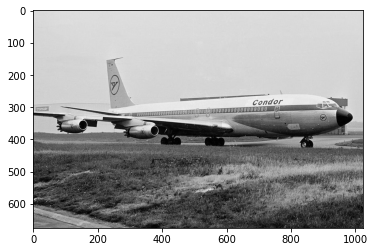

In [ ]:
pic = cv2.imread('gdrive/MyDrive/top_gun_dl/repo/data/images/cropped/1025794.jpg')

plt.imshow(pic)

## Create a Dataset

In [ ]:
class AirplaneDataset(Dataset):
    def __init__(self, df, class_dict, resize_image=True, augment=False):
        self.df = df
        # label dictionary
        classes = self.df.label.unique()
        self.label_dict = {k: v for v, k in enumerate(classes)}
        self.augment = augment
        self.resize_image = resize_image
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        
        path_file = row['path']
        
        # read img
        img = cv2.imread(path_file)
        
        # convert to RGB
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        if self.resize_image:
            try:
                img = cv2.resize(img, (256,256))
            except:
                print(path)
        
        # move color channels to correct spot
        img = np.transpose(img, (2, 0, 1))
        
        if self.augment == True:
            transform = A.Compose([
                # spatial transforms
                A.HorizontalFlip(p=.5),
                A.VerticalFlip(p=.5),
                A.Rotate(limit = 10, 
                         border_mode = cv2.BORDER_CONSTANT, p = .75),
                
                # pixel-level transformation
                A.RandomBrightnessContrast(p=0.5)])
            img = transform(image=img)['image']
            
        # convert to [0,1] scale
        img = torch.tensor(img / 255.).float()
        # access the label dictionary
        label = torch.tensor(self.label_dict[row['label']])

        return img, label
        

In [ ]:
train_df.head()

,image,dataset,label,path
0,1025794.jpg,train,Boeing 707,gdrive/MyDrive/top_gun_dl/repo/data/images/cro...
1,1340192.jpg,train,Boeing 707,gdrive/MyDrive/top_gun_dl/repo/data/images/cro...
2,0056978.jpg,train,Boeing 707,gdrive/MyDrive/top_gun_dl/repo/data/images/cro...
3,0698580.jpg,train,Boeing 707,gdrive/MyDrive/top_gun_dl/repo/data/images/cro...
4,0450014.jpg,train,Boeing 707,gdrive/MyDrive/top_gun_dl/repo/data/images/cro...


In [ ]:
# First we need to label encode the classes
classes = sorted(train_df.label.unique())

# Creating the label dictionary for all classes ... interesting that I only see 70 here!?
class_dict = {c:i for i,c in enumerate(classes)} # class to ID

In [ ]:
# Creating DataSets
train_ds = AirplaneDataset(train_df, class_dict, resize_image=True, augment=True)
valid_ds = AirplaneDataset(valid_df, class_dict, resize_image=True)

# Sending to DataLoaders
BatchSize = 32
train_dl = DataLoader(train_ds, batch_size=BatchSize, shuffle=True)
valid_dl = DataLoader(valid_ds, batch_size=8, shuffle=False)

In [ ]:
def topk_accuracy(y, y_hat, correct_list, incorrect_list):
    length = len(y)
    correct = 0
    onepass_correct = []
    onepass_incorrect = []
    for i in range(length):
        if y[i] in y_hat[i]:
            # add the index, label and prediction to a list
            onepass_correct.append((i, y[i], y_hat[i]))
            correct += 1
        else:
          # add the index, label and prediction to a list
          onepass_incorrect.append((i, y[i], y_hat[i]))

    # add the list to the full list
    correct_list.append(onepass_correct)
    incorrect_list.append(onepass_incorrect)

    return round(correct / length, 3), correct_list, incorrect_list

In [ ]:
def one_pass(model, dataloader, optimizer, loss_function, correct_list, incorrect_list, train=False):
    losses = []
    actual = []
    topk_list = []
    predictions = []
    
    for x, y in tqdm(dataloader):
        x, y = x.to(device), y.to(device)
        if not train:
            model.eval()
        else:
            model.train()
            
        model.train()
        y_hat = model(x)
        argmax = torch.argmax(y_hat, dim=1)
        loss = loss_function(y_hat, y)

        # get the top k
        topk = torch.topk(y_hat, k=5, dim=1, largest=True)

        # detach
        label_actual = y.cpu().detach().numpy()
        label_pred = argmax.cpu().detach().numpy()

        # add to the lists
        actual.extend(label_actual)
        predictions.extend(label_pred)
        topk_list.extend(topk.indices.cpu().detach().numpy())    # pass the indices to the list

        # if train is true, backprop.
        if train:
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        
        losses.append(loss.item())
  
    # calculate accuracy
    topk_acc, correct_list, incorrect_list = topk_accuracy(actual, topk_list, correct_list, incorrect_list)
    accuracy = round(accuracy_score(actual, predictions), 3)
    average_loss = np.mean(losses)
    return average_loss, accuracy, topk_acc, correct_list, incorrect_list

## Train Model

In [ ]:
def train_model(model, train_dl, test_df, epochs=5, lr=0.01, optimizer=None):
    correct_list_train = []
    incorrect_list_train = []
    correct_list_val = []
    incorrect_list_val = []

    if optimizer:
        optimizer = optimizer
    else:
        optimizer = optim.Adam(model.parameters(), lr = lr)
    loss_function = nn.CrossEntropyLoss()
    for epoch in range(epochs):
        train_loss, train_acc, train_k, correct_list_train, incorrect_list_train = one_pass(model, 
                                                                                            train_dl, 
                                                                                            optimizer, 
                                                                                            loss_function, 
                                                                                            correct_list_train, 
                                                                                            incorrect_list_train, 
                                                                                            train=True)
        
        val_loss, val_acc, val_k, correct_list_val, incorrect_list_val = one_pass(model, 
                                                                                  test_df, 
                                                                                  optimizer, 
                                                                                  loss_function, 
                                                                                  correct_list_val, 
                                                                                  incorrect_list_val, 
                                                                                  train=False)
        
        print('Training Loss:', round(train_loss, 3))
        print(f"Epoch Number: {epoch+1}. Training Top 5 Accuracy: {train_k} Test Top 5 Accuracy: {val_k}")
    
    return correct_list_train, incorrect_list_train, correct_list_val, incorrect_list_val

In [ ]:
# convert to gpu
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

## VGG-16

In [ ]:
from torchvision import models, transforms

vgg = models.vgg16(pretrained=True)

In [ ]:
# turn off gradients for all the parameters
for param in vgg.parameters():
            param.requires_grad = False

In [ ]:
# change the last layer
vgg.classifier[6] = nn.Linear(4096, 70)

In [ ]:
# double-check all the parameters
for name, param in vgg.named_parameters():
    print(f"{name} gradient is set to", param.requires_grad)

features.0.weight gradient is set to False
features.0.bias gradient is set to False
features.2.weight gradient is set to False
features.2.bias gradient is set to False
features.5.weight gradient is set to False
features.5.bias gradient is set to False
features.7.weight gradient is set to False
features.7.bias gradient is set to False
features.10.weight gradient is set to False
features.10.bias gradient is set to False
features.12.weight gradient is set to False
features.12.bias gradient is set to False
features.14.weight gradient is set to False
features.14.bias gradient is set to False
features.17.weight gradient is set to False
features.17.bias gradient is set to False
features.19.weight gradient is set to False
features.19.bias gradient is set to False
features.21.weight gradient is set to False
features.21.bias gradient is set to False
features.24.weight gradient is set to False
features.24.bias gradient is set to False
features.26.weight gradient is set to False
features.26.bias g

In [ ]:
vgg.to(device)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [ ]:
correct_train, incorrect_train, correct_val, incorrect_val = train_model(vgg, train_dl, valid_dl, epochs=8)

  0%|          | 0/209 [00:00<?, ?it/s]

  0%|          | 0/417 [00:00<?, ?it/s]

Training Loss: 9.221
Epoch Number: 1. Training Top 5 Accuracy: 0.249 Test Top 5 Accuracy: 0.324


  0%|          | 0/209 [00:00<?, ?it/s]

  0%|          | 0/417 [00:00<?, ?it/s]

Training Loss: 11.266
Epoch Number: 2. Training Top 5 Accuracy: 0.285 Test Top 5 Accuracy: 0.359


  0%|          | 0/209 [00:00<?, ?it/s]

  0%|          | 0/417 [00:00<?, ?it/s]

Training Loss: 12.086
Epoch Number: 3. Training Top 5 Accuracy: 0.324 Test Top 5 Accuracy: 0.39


  0%|          | 0/209 [00:00<?, ?it/s]

  0%|          | 0/417 [00:00<?, ?it/s]

Training Loss: 12.977
Epoch Number: 4. Training Top 5 Accuracy: 0.326 Test Top 5 Accuracy: 0.383


  0%|          | 0/209 [00:00<?, ?it/s]

  0%|          | 0/417 [00:00<?, ?it/s]

Training Loss: 13.359
Epoch Number: 5. Training Top 5 Accuracy: 0.343 Test Top 5 Accuracy: 0.398


  0%|          | 0/209 [00:00<?, ?it/s]

  0%|          | 0/417 [00:00<?, ?it/s]

Training Loss: 13.754
Epoch Number: 6. Training Top 5 Accuracy: 0.354 Test Top 5 Accuracy: 0.435


  0%|          | 0/209 [00:00<?, ?it/s]

  0%|          | 0/417 [00:00<?, ?it/s]

Training Loss: 14.294
Epoch Number: 7. Training Top 5 Accuracy: 0.36 Test Top 5 Accuracy: 0.419


  0%|          | 0/209 [00:00<?, ?it/s]

  0%|          | 0/417 [00:00<?, ?it/s]

Training Loss: 14.392
Epoch Number: 8. Training Top 5 Accuracy: 0.361 Test Top 5 Accuracy: 0.423


In [ ]:
def get_count_dictionary(idx_label_array):
    dictionary = {}
    for epoch in idx_label_array:
        for img in epoch:
            idx, label, array = img[0], img[1], img[2]
            if idx not in dictionary:
                dictionary[idx] = 1
            else:
                dictionary[idx] += 1
    
    return dictionary

In [ ]:
def get_image_df(idx_label_array, valid_dataframe):
    response_dict = get_count_dictionary(idx_label_array)
    five_list = []
    values = []
    for k, v in response_dict.items():
        five_list.append(k)
        values.append(v)
    # five list is now the list of indices that were classified correct/incorrect 5 times
    dataframe = valid_dataframe.iloc[five_list, :].copy()
    dataframe['count'] = values
    return dataframe

In [ ]:
correct_df = get_image_df(correct_val, valid_df)
incorrect_df = get_image_df(incorrect_val, valid_df)

In [ ]:
correct_df.to_csv('gdrive/MyDrive/top_gun_dl/correct_VGG.csv')
incorrect_df.to_csv('gdrive/MyDrive/top_gun_dl/incorrect_VGG.csv')

In [ ]:
correct_df

,image,dataset,label,path,count
5,1446335.jpg,validation,Boeing 707,gdrive/MyDrive/top_gun_dl/repo/data/images/cro...,2
9,0536515.jpg,validation,Boeing 707,gdrive/MyDrive/top_gun_dl/repo/data/images/cro...,1
19,0725155.jpg,validation,Boeing 707,gdrive/MyDrive/top_gun_dl/repo/data/images/cro...,4
22,1338874.jpg,validation,Boeing 707,gdrive/MyDrive/top_gun_dl/repo/data/images/cro...,3
23,0812908.jpg,validation,Boeing 707,gdrive/MyDrive/top_gun_dl/repo/data/images/cro...,2
...,...,...,...,...,...
3270,0808929.jpg,validation,Tu-154,gdrive/MyDrive/top_gun_dl/repo/data/images/cro...,1
3282,1177961.jpg,validation,Tu-154,gdrive/MyDrive/top_gun_dl/repo/data/images/cro...,1
3287,1273293.jpg,validation,Tu-154,gdrive/MyDrive/top_gun_dl/repo/data/images/cro...,1
3291,0255359.jpg,validation,Tu-154,gdrive/MyDrive/top_gun_dl/repo/data/images/cro...,1
